In [46]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import xgboost as xgb

In [47]:
# Load data
df = pd.read_csv('ad_records.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1


In [48]:
# Feature Engineering
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Is_Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

def part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['Part_Of_Day'] = df['Hour'].apply(part_of_day)
df['Part_Of_Day'] = LabelEncoder().fit_transform(df['Part_Of_Day'])

df['AgeGroup'] = pd.cut(df['Age'], bins=[17, 25, 35, 50, 65], labels=[0, 1, 2, 3])
df['IncomeGroup'] = pd.qcut(df['Area Income'], q=4, labels=[0, 1, 2, 3])

df['Site_Internet_Interaction'] = df['Daily Time Spent on Site'] * df['Daily Internet Usage']
df['Age_Income_Interaction'] = df['Age'] * df['Area Income']
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad,Hour,Day,Month,DayOfWeek,Is_Weekend,Part_Of_Day,AgeGroup,IncomeGroup,Site_Internet_Interaction,Age_Income_Interaction
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0,21,9,6,3,0,3,1,3,10760.3958,2223419.20
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0,17,16,1,5,1,1,1,2,8645.2041,1917048.06
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0,10,29,6,2,0,2,1,2,7673.6520,1736314.50
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0,14,21,6,1,0,0,1,1,12405.3396,1573066.04
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1,10,21,7,3,0,2,1,1,9919.7518,1629741.90


In [49]:
# Label encoding
label_encoders = {}
for col in ['City', 'Gender', 'Country']:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad,Hour,Day,Month,DayOfWeek,Is_Weekend,Part_Of_Day,AgeGroup,IncomeGroup,Site_Internet_Interaction,Age_Income_Interaction
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,234,1,174,2016-06-09 21:43:05,0,21,9,6,3,0,3,1,3,10760.3958,2223419.20
1,41.73,31.0,61840.26,207.17,Optional full-range projection,460,1,166,2016-01-16 17:56:05,0,17,16,1,5,1,1,1,2,8645.2041,1917048.06
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,379,0,71,2016-06-29 10:50:45,0,10,29,6,2,0,2,1,2,7673.6520,1736314.50
3,59.88,28.0,56180.93,207.17,Balanced empowering success,269,0,205,2016-06-21 14:32:32,0,14,21,6,1,0,0,1,1,12405.3396,1573066.04
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,495,0,149,2016-07-21 10:54:35,1,10,21,7,3,0,2,1,1,9919.7518,1629741.90


In [50]:

# Drop unused columns
x = df.drop(['Clicked on Ad', 'Ad Topic Line', 'Timestamp'], axis=1)
y = df['Clicked on Ad']

In [51]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [52]:
# Random Forest Classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(x_train, y_train)
y_pred_rf = clf_rf.predict(x_test)
print(f"RandomForest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

RandomForest Accuracy: 0.8400


In [53]:
print("\nRandomForest Classification Report:")
print(pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).transpose())

print("RandomForest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


RandomForest Classification Report:
              precision    recall  f1-score  support
0              0.827977  0.863905  0.845560  1014.00
1              0.853503  0.815416  0.834025   986.00
accuracy       0.840000  0.840000  0.840000     0.84
macro avg      0.840740  0.839661  0.839792  2000.00
weighted avg   0.840562  0.840000  0.839873  2000.00
RandomForest Confusion Matrix:
[[876 138]
 [182 804]]


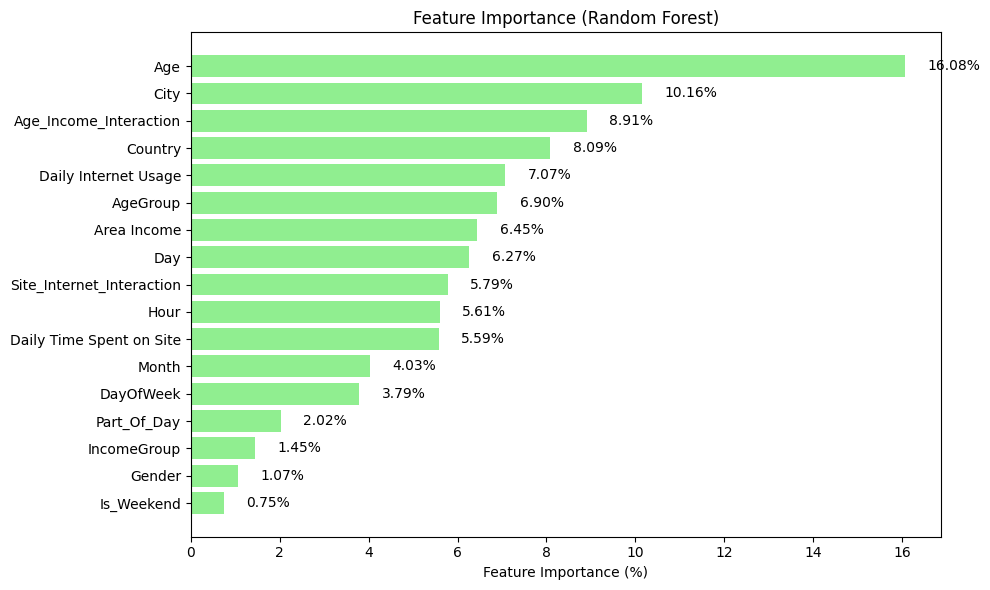

In [54]:
# Random Forest Feature Importance
rf_importances = clf_rf.feature_importances_
rf_feature_names = x_train.columns
rf_importance_df = pd.DataFrame({
    'feature': rf_feature_names,
    'importance': (rf_importances / sum(rf_importances)) * 100
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(rf_importance_df['feature'], rf_importance_df['importance'], color='lightgreen')
plt.xlabel('Feature Importance (%)')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
for i, v in enumerate(rf_importance_df['importance']):
    plt.text(v + 0.5, i, f"{v:.2f}%", va='center')
plt.tight_layout()
plt.show()

In [55]:
# XGBoost with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Convert categorical columns to int before fitting
x_train['AgeGroup'] = x_train['AgeGroup'].astype(int)
x_train['IncomeGroup'] = x_train['IncomeGroup'].astype(int)
x_test['AgeGroup'] = x_test['AgeGroup'].astype(int)
x_test['IncomeGroup'] = x_test['IncomeGroup'].astype(int)

In [56]:
xgb_clf = xgb.XGBClassifier(random_state=42)
grid = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, scoring='f1', verbose=1)
grid.fit(x_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Accuracy: 0.8750


In [57]:

# Evaluation
print(f"Best Hyperparameters: {grid.best_params_}")


Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [58]:
print("\nClassification Report:")
print(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose())


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support
0              0.875246  0.878698  0.876969  1014.000
1              0.874745  0.871197  0.872967   986.000
accuracy       0.875000  0.875000  0.875000     0.875
macro avg      0.874995  0.874947  0.874968  2000.000
weighted avg   0.874999  0.875000  0.874996  2000.000

Confusion Matrix:
[[891 123]
 [127 859]]


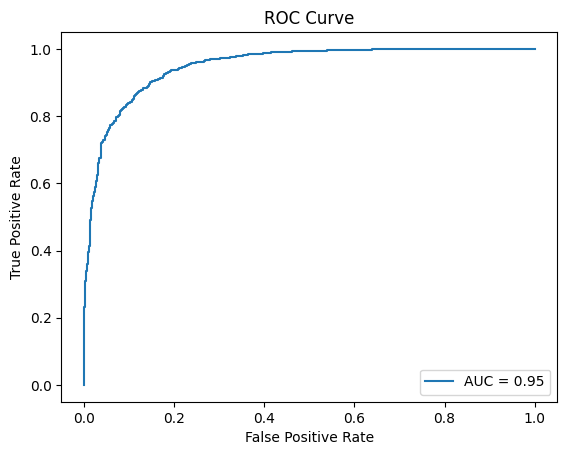

In [59]:

# AUC-ROC Curve
probs = best_model.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, probs):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


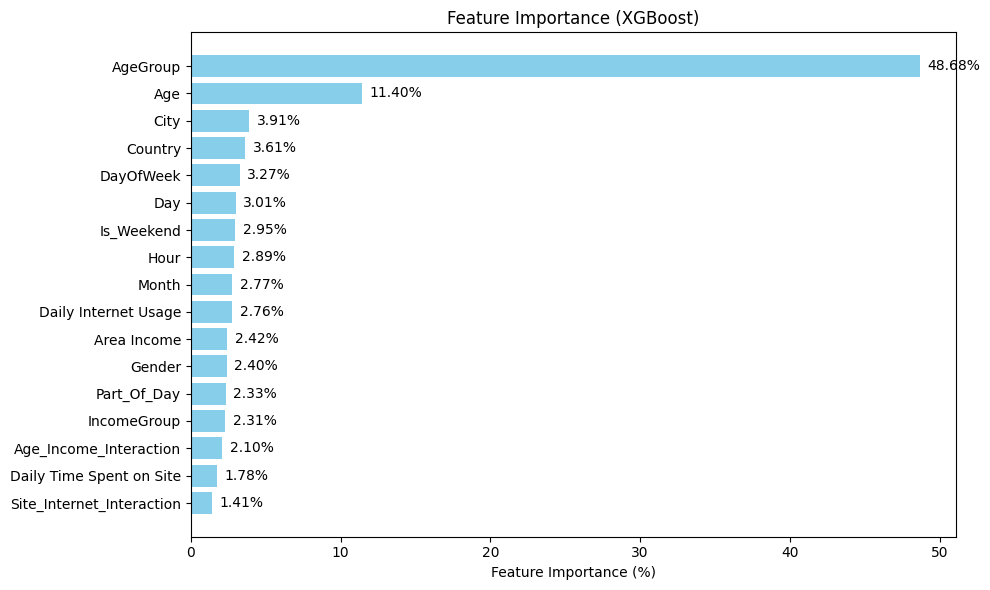

In [60]:
# Feature importance (XGBoost)
feature_importances = best_model.feature_importances_
feature_names = x_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': (feature_importances / sum(feature_importances)) * 100
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel('Feature Importance (%)')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
for i, v in enumerate(importance_df['importance']):
    plt.text(v + 0.5, i, f"{v:.2f}%", va='center')
plt.tight_layout()
plt.show()
